In [16]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

results_path = "../results"

dfs = []

for file_path in glob(os.path.join(results_path, "*average_results.csv")):
    file_name = os.path.basename(file_path)
    df = pd.read_csv(file_path, index_col=0)
    df['Source_File'] = file_name
    columns = ['Source_File'] + [col for col in df.columns if col != 'Source_File']
    df = df[columns]
    dfs.append(df)


all_models_results = pd.concat(dfs, ignore_index=True)


In [17]:
best_models_files = [
    "20241203_2115_lr_average_results.csv",
    "20241203_2115_knn_average_results.csv",
    "20241203_2138_rf_average_results.csv",
    "20241203_2255_lr_average_results.csv"
]

filtered_results = all_models_results[
    all_models_results['Source_File'].isin(best_models_files)
]
filtered_results

,Source_File,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE


In [ ]:

# Example usage:
# For MAPE
fig_mape, summary_mape = create_model_comparison(metric='MAPE')
print("\nMAPE Summary Table:")
print(summary_mape)

# For R²
fig_r2, summary_r2 = create_model_comparison(metric='R²')
print("\nR² Summary Table:")
print(summary_r2)

# For RMSE
fig_rmse, summary_rmse = create_model_comparison(metric='RMSE')
print("\nRMSE Summary Table:")
print(summary_rmse)

# Close all figures to free memory
plt.close('all')

In [18]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_model_comparison(metric='MAPE', results_path="../results", save_plot=True):
    """
    Create a comparison plot for different models using a specified metric.
    
    Parameters:
    -----------
    metric : str
        The metric to compare. Options: 'MAPE', 'R²', 'MSE', 'RMSE', 'MAE', 'WAPE'
    results_path : str
        Path to the results directory
    save_plot : bool
        Whether to save the plot to file
        
    Returns:
    --------
    tuple: (figure, summary_table)
        The generated plot and a summary table of the results
    """
    
    # Metric configuration
    metric_config = {
        'MAPE': {'format': '%.1f%%', 'label': 'MAPE (%)', 'limits': (0, 100)},
        'R²': {'format': '%.3f', 'label': 'R²', 'limits': (-1, 1)},
        'MSE': {'format': '%.1f', 'label': 'MSE', 'limits': (0, None)},
        'RMSE': {'format': '%.1f', 'label': 'RMSE', 'limits': (0, None)},
        'MAE': {'format': '%.1f', 'label': 'MAE', 'limits': (0, None)},
        'WAPE': {'format': '%.1f%%', 'label': 'WAPE (%)', 'limits': (0, 100)}
    }
    
    if metric not in metric_config:
        raise ValueError(f"Metric must be one of {list(metric_config.keys())}")
    
    # Load results
    dfs = []
    for file_path in glob(os.path.join(results_path, "*average_results.csv")):
        file_name = os.path.basename(file_path)
        df = pd.read_csv(file_path, index_col=0)
        df['Source_File'] = file_name
        columns = ['Source_File'] + [col for col in df.columns if col != 'Source_File']
        df = df[columns]
        dfs.append(df)

    all_models_results = pd.concat(dfs, ignore_index=True)

    # Mapping dictionaries
    strategy_names = {
        'within_domain': 'Within Domain',
        'cross_domain': 'Cross Domain',
        'all_domain': 'All Domain'
    }

    model_names = {
        'LinearRegression': 'LR',
        'KNeighborsRegressor': 'KNN',
        'RandomForestRegressor': 'RF',
        'XGBRegressor': 'XGB',
        'CatBoostRegressor': 'CAT'
    }

    target_names = {
        'Non-residential EUI (kWh/m2/year)': 'Non-residential',
        'Residential EUI (kWh/m2/year)': 'Residential'
    }

    custom_palette = {
        'Non-residential': '#2ecc71',
        'Residential': '#3498db'
    }

    # Create plot
    fig, axes = plt.subplots(1, 3, figsize=(22, 8))
    strategies = ['within_domain', 'cross_domain', 'all_domain']

    # Calculate dynamic limits
    min_val = all_models_results[metric].min()
    max_val = all_models_results[metric].max()
    padding = (max_val - min_val) * 0.1
    
    # Set y-axis limits based on metric configuration
    base_min, base_max = metric_config[metric]['limits']
    y_min = base_min if base_min is not None else max(min_val - padding, 0)
    y_max = base_max if base_max is not None else max_val + padding

    for ax, strategy in zip(axes, strategies):
        strategy_results = all_models_results[all_models_results['Strategy'] == strategy].copy()
        strategy_results['Model'] = strategy_results['Model'].map(model_names)
        strategy_results['Target'] = strategy_results['Target'].map(target_names)
        
        # Create bar plot
        bars = sns.barplot(
            data=strategy_results,
            x='Model',
            y=metric,
            hue='Target',
            palette=custom_palette,
            ax=ax
        )
        
        # Add value labels
        for container in bars.containers:
            bars.bar_label(container, 
                          fmt=metric_config[metric]['format'], 
                          padding=5, 
                          fontsize=11)
        
        # Customize appearance
        ax.set_title(f'{strategy_names[strategy]}',
                    fontsize=16,
                    pad=20,
                    fontweight='bold')
        ax.set_ylabel(metric_config[metric]['label'], fontsize=14)
        ax.set_ylim(y_min, y_max)
        
        # Add baseline
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
        
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Position legend
        if strategy == 'cross_domain':
            ax.legend(bbox_to_anchor=(0.5, -0.2),
                     loc='upper center',
                     ncol=2,
                     fontsize=12)
        else:
            ax.legend([],[], frameon=False)

    plt.tight_layout()

    # Save plot if requested
    if save_plot:
        plt.savefig(f'../figures/model_plots/model_comparison_{metric.lower()}.png', 
                    dpi=300, 
                    bbox_inches='tight')

    # Create summary table
    summary = all_models_results.pivot_table(
        index=['Model', 'Target'],
        columns='Strategy',
        values=metric
    ).round(3 if metric == 'R²' else 1)
    
    return fig, summary


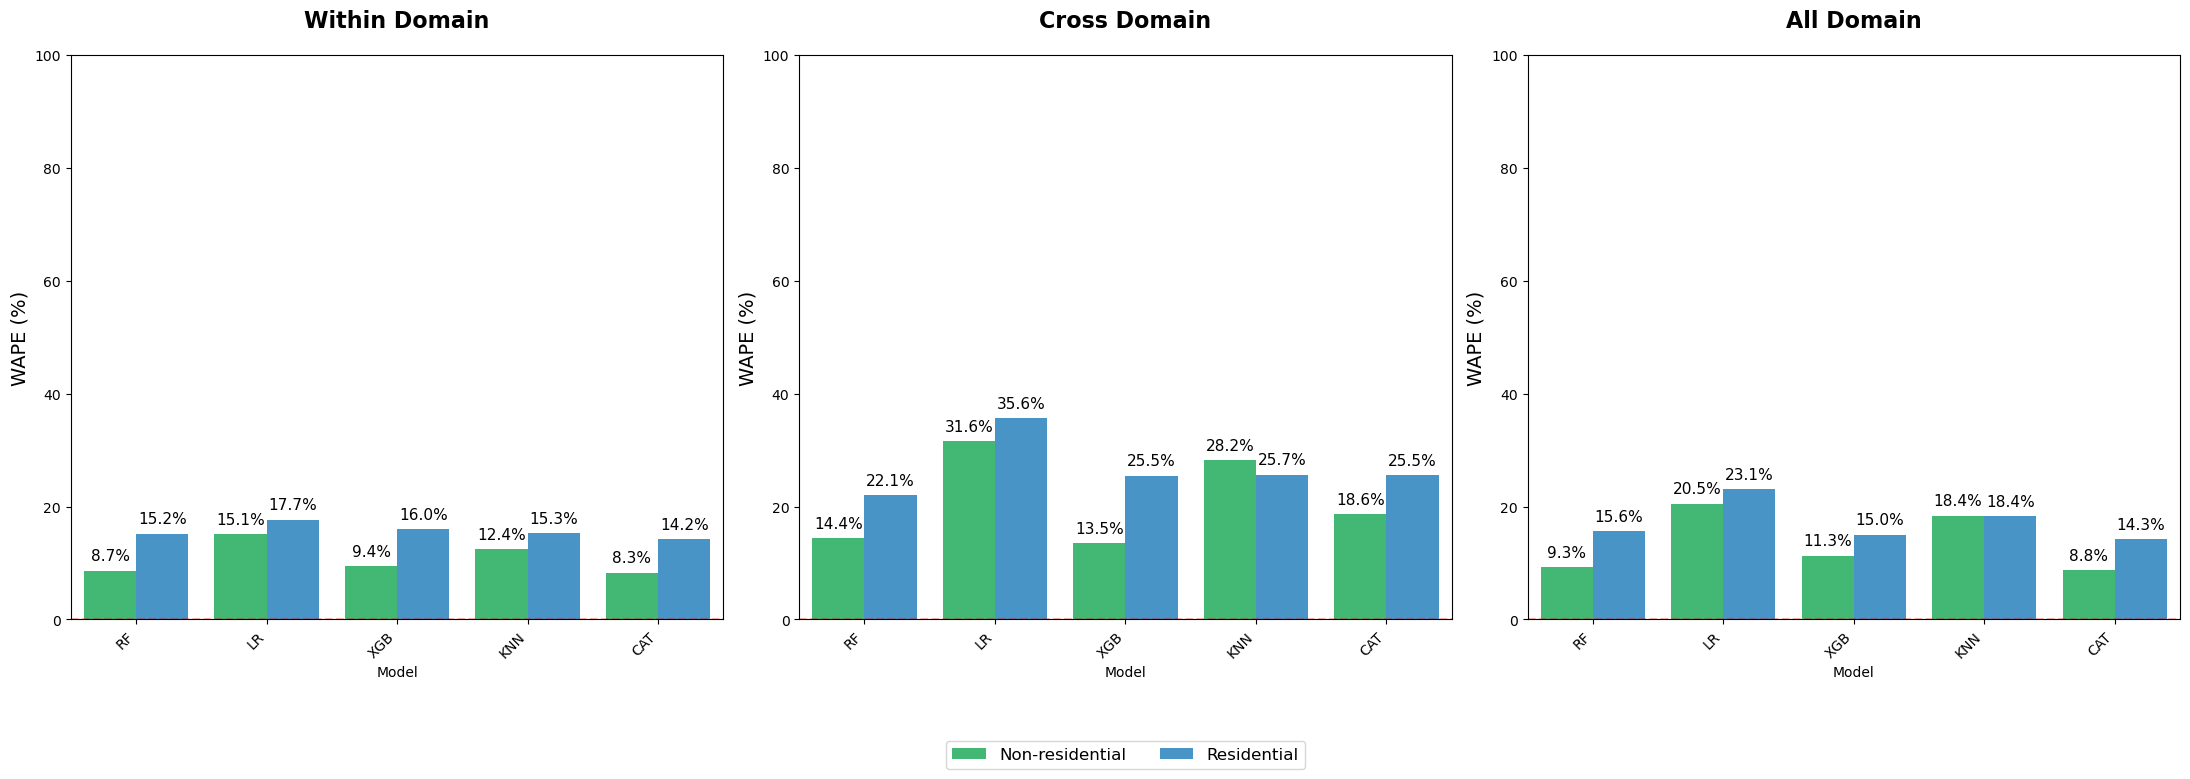

In [26]:
fig_mape, summary_mape = create_model_comparison(metric='WAPE')
 

In [20]:
summary_mape

Strategy                                                 all_domain  \
Model                 Target                                          
CatBoostRegressor     Non-residential EUI (kWh/m2/year)         8.8   
                      Residential EUI (kWh/m2/year)            14.1   
KNeighborsRegressor   Non-residential EUI (kWh/m2/year)        18.9   
                      Residential EUI (kWh/m2/year)            19.0   
LinearRegression      Non-residential EUI (kWh/m2/year)        21.5   
                      Residential EUI (kWh/m2/year)            25.4   
RandomForestRegressor Non-residential EUI (kWh/m2/year)         9.5   
                      Residential EUI (kWh/m2/year)            15.7   
XGBRegressor          Non-residential EUI (kWh/m2/year)        11.3   
                      Residential EUI (kWh/m2/year)            15.2   

Strategy                                                 cross_domain  \
Model                 Target                                            
CatBoostRegressor     Non-residential EUI (kWh/m2/year)          18.6   
                      Residential EUI (kWh/m2/year)              25.4   
KNeighborsRegressor   Non-residential EUI (kWh/m2/year)          28.5   
                      Residential EUI (kWh/m2/year)              27.3   
LinearRegression      Non-residential EUI (kWh/m2/year)          32.5   
                      Residential EUI (kWh/m2/year)              40.8   
RandomForestRegressor Non-residential EUI (kWh/m2/year)          14.0   
                      Residential EUI (kWh/m2/year)              24.9   
XGBRegressor          Non-residential EUI (kWh/m2/year)          13.7   
                      Residential EUI (kWh/m2/year)              26.1   

Strategy                                                 within_domain  
Model                 Target                                            
CatBoostRegressor     Non-residential EUI (kWh/m2/year)            8.6  
                      Residential EUI (kWh/m2/year)               13.1  
KNeighborsRegressor   Non-residential EUI (kWh/m2/year)           12.5  
                      Residential EUI (kWh/m2/year)               15.8  
LinearRegression      Non-residential EUI (kWh/m2/year)           17.7  
                      Residential EUI (kWh/m2/year)               20.4  
RandomForestRegressor Non-residential EUI (kWh/m2/year)            8.6  
                      Residential EUI (kWh/m2/year)               14.2  
XGBRegressor          Non-residential EUI (kWh/m2/year)            9.1  
                      Residential EUI (kWh/m2/year)               15.1